In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [1022]:
import statsmodels.api as sm


In [779]:
import copy

In [274]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!ls data

ftx-futures
ftx_book_snapshot_25_2020-01-01_BTC-PERP.csv.gz


In [4]:
# data url: http://daweb.ism.ac.jp/yosoku/

# 直接読み込む場合 
#df = pd.read_csv("http://daweb.ism.ac.jp/yosoku/materials/PF-example-data.txt", header=-1)

# 別途ダウンロードしてから取り込む場合
df= pd.read_csv("data/ftx_book_snapshot_25_2020-01-01_BTC-PERP.csv.gz")
df['simple_mid'] = 0.5*(df['bids[0].price']+df['asks[0].price'])


Text(0.5, 1.0, 'Test Data')

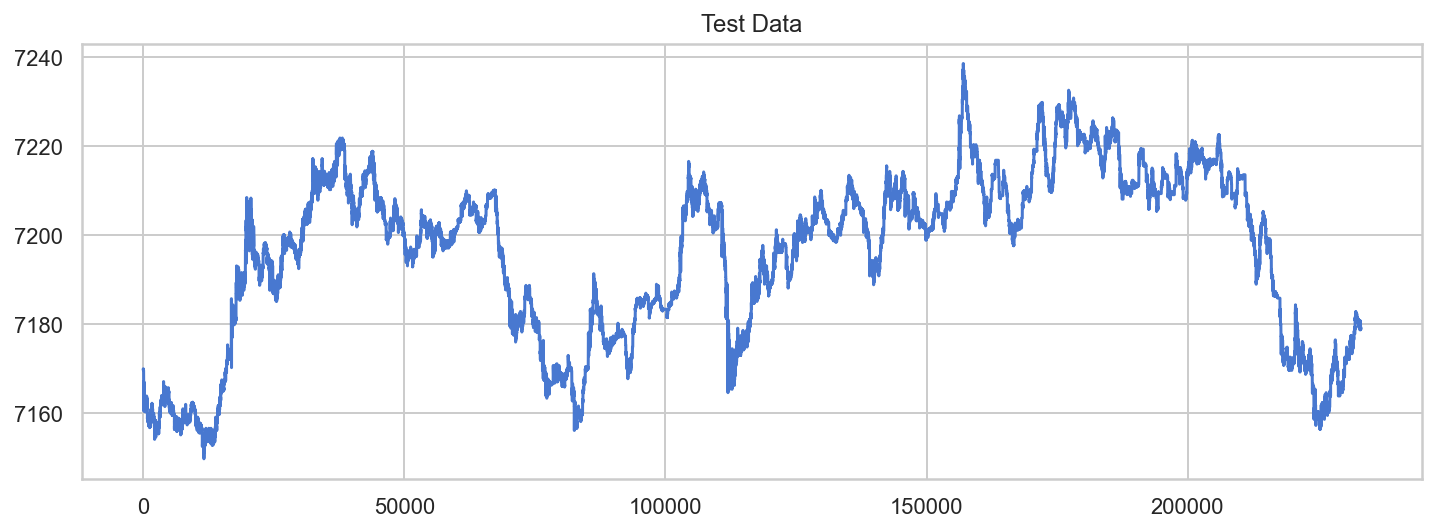

In [6]:
df['simple_mid'].plot(figsize=(12,4))
plt.title("Test Data")

In [12]:
df['ret'] = df['simple_mid'].pct_change()
df['ret']

0              NaN
1         0.000000
2         0.000017
3         0.000000
4         0.000000
            ...   
233149    0.000000
233150    0.000000
233151    0.000070
233152    0.000000
233153    0.000000
Name: ret, Length: 233154, dtype: float64

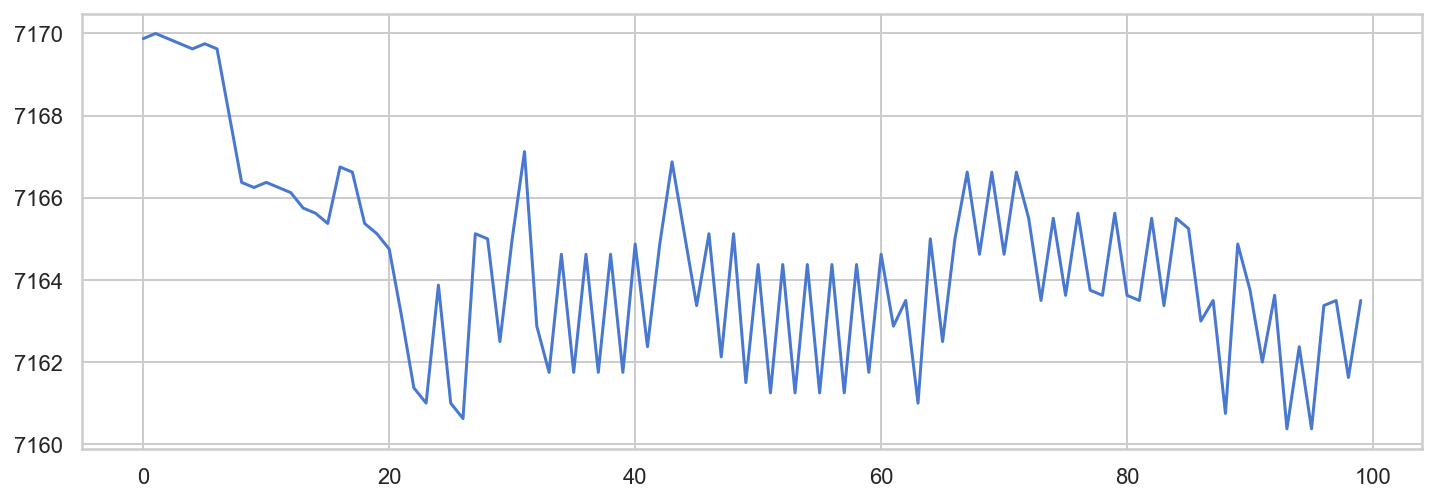

In [61]:
cleaned_df = df[df.ret!=0].reset_index()
cleaned_df.simple_mid.iloc[:100].plot(figsize=(12,4))

In [1018]:
class ParticleFilter(object):
    def __init__(self, y, n_particle, sigma_2, alpha_2):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf

    
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
        # print(f"u: {u}")
        if np.any(w_cumsum < u) == False:
            return 0
        k = np.max(idx[w_cumsum < u])
        return k +1

    def resampling(self, weights):
        '''
        generate x_resampled[t+1] = x[t+1, k]

        '''
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        # print(f"idx shape: {idx.shape}")
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))

        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def gen_price_diff_dist(self,t):
        self.price_diff_dist = np.asarray(
            np.unique(np.diff(self.y,1)[t-self.roll_window:t], return_counts=True)).T
        
        
        self.price_diff_dist[:,1] =self.price_diff_dist[:,1]/ self.price_diff_dist[:,1].sum()
        # self.price_diff_dist = pd.DataFrame(self.price_diff_dist, columns=['price_diff', 'likelihood'])
        
    def likelihood_price_dist_lookup(self,y, x):
        
        
        
        ## shift price diff dist by particle price (x) to get price dist of x
        p_dist = copy.deepcopy(self.price_diff_dist)
        p_dist[:,0] = p_dist[:, 0] + x
        
        # print(f"y: {y} p_dist[:,0]: {p_dist[:,0]}")
        idx_likelihood = np.searchsorted(p_dist[:,0], y, side='left')
        
        

        try:
            
            return p_dist[idx_likelihood, 1]
        except:
            return p_dist[idx_likelihood-1, 1]
    def gen_v(self):
        return np.random.choice(self.price_diff_dist[:,0], size=1, p= self.price_diff_dist[:,1])[0]
    
    def neff(self, weights):
        '''
        calculate “effective sample size (ESS)"
        '''
        return 1. / np.sum(np.square(weights))
    
    def get_x_dist(self, x,t):

        x_dist = np.asarray(np.unique(x[t,:], return_counts=True)).T
        # print("calc x_dist")
        # print(x_dist)
        x_dist[:,1] =  x_dist[:,1]/  x_dist[:,1].sum()
        return x_dist
    
    def p_x(self, x_dist, x):
        idx = np.searchsorted(x_dist[:,0], x, side='left')
        return sample_dist[idx,1]
    
    def backward_smoother(self,w_normed, x,t):
        
        ## x[t+1, :] is the current particles
        ## w_normed[t] is the current normalised weight
        ## x[t, :] is the previous particles
        ## w_normed[t-1] is the previous normalised weight
        
        # print(f"prev_x_dist: {prev_x_dist}")
        
        
        # w_smoother = np.zeros( self.n_particle)
        
        denoms = np.zeros( self.n_particle)
        for j in range(self.n_particle):
            # print(f"x[t+1, j]: {x[t+1, j]}")

            for k in range(self.n_particle):
#                 print(f"w_normed[t-1,k]: {w_normed[t-1,k]}")
#                 print(f"prev_x_dist: {prev_x_dist}")
#                 print(f"self.likelihood_price_dist_lookup(prev_x_dist, x[t+1, j]): {self.likelihood_price_dist_lookup(prev_x_dist, x[t+1, j])}")
                denoms[j] += w_normed[t-1,k] * self.likelihood_price_dist_lookup(x[t+1, j], x[t, k])
                
            # denoms[j] = sum([w_normed[t-1,k] * self.likelihood_price_dist_lookup(prev_x_dist, x[t+1, j]) for k in range(self.n_particle)])
        
        
        for i in range(self.n_particle):
            # print(f"i: {i}")
            p_j = np.zeros(self.n_particle)
            for j in range(self.n_particle):
                p_j[j] = self.likelihood_price_dist_lookup(x[t+1, j], x[t, i])
                        
            # print(f"dim check {w_normed[t]} {p_j} {denoms}")
            sum_j = np.sum(w_normed[t] * p_j / denoms)
            w_normed[t, i] = w_normed[t-1,i] * sum_j
        
        return w_normed
        
        
        
    
    def simulate(self, roll_window, method, smoother='fixed_lag', seed=71):
        
        self.roll_window = roll_window
        self.method=method
        rd.seed(seed)
        
        if smoother=='fixed_lag':
            counter = 0

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle))
        x_resampled = np.zeros((T+1, self.n_particle))
        
        # 潜在変数の初期値
        # initial_x = rd.normal(0, 1, size=self.n_particle)
        
        initial_x = self.y[roll_window-1]

        x[roll_window] = x_resampled[roll_window] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度
        

        for t in range(T):
            if t < self.roll_window:
                pass

                
            else:
                print("\r calculating... t={}".format(t), end="")
                
                self.gen_price_diff_dist(t)
                
                # print(f"v dist: {np.average(self.price_diff_dist['price_diff'],weights=self.price_diff_dist['likelihood']) }")
                
                for i in range(self.n_particle):

                    # 1階差分トレンドを適用

                    ## draw sample noise from rolling window
                    # v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                    
                    if method=='emp':
                        v = self.gen_v()
                        x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                        w[t, i] = self.likelihood_price_dist_lookup(self.y[t], x[t+1, i])
                    elif method=='normal':
                        v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                        x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                        w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2) # y[t]Likelihood of each particle with respect to
                
                w_normed[t] = w[t]/np.sum(w[t]) # 規格化
                
                _unsmoothed_w_normed_t = copy.deepcopy(w_normed[t])
                
                
                l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度
                
#                 print('w_normed')
#                 print(w_normed)
                
    
    
                ##Smoother
        
                if smoother:
                    if smoother=='fixed_lag':
                        if counter==0:
                            k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
                            x_resampled[t+1] = x[t+1, k]
                            counter+=1
                        else:
                            x_resampled[t+1] = x[t+1, :]
                            counter-=1
                            
                    if smoother== 'backward':                        
                        if t!=self.roll_window:
                            w_normed = self.backward_smoother(w_normed, x,t)
                            w_normed[t] = w_normed[t]/np.sum(w_normed[t]) 
                        
                        k = self.resampling(w_normed[t]) 
                        x_resampled[t+1] = x[t+1, k]
                    
                    if smoother=='ess':
                        if self.neff(w_normed[t]) < self.n_particle/2:
                            k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
                            x_resampled[t+1] = x[t+1, k]
                        else:
                            x_resampled[t+1] = x[t+1, :]


                else:
                    k = self.resampling(w_normed[t])
                    x_resampled[t+1] = x[t+1, k]
                
                
                # 全体の対数尤度
                self.log_likelihood = np.sum(l) - T*np.log(n_particle)

                self.x = x
                self.x_resampled = x_resampled
                self.w = w
                self.w_normed = w_normed
                self.l = l

    def get_filtered_value(self, lagged_weight):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        shifted_n = 1
        x_mean = np.diag(np.dot(self.w_normed, self.x[1:].T))
        self.x_mean = x_mean
        
        shifted_x_mean = np.roll(pf.x_mean, shifted_n)
        shifted_x_mean[:shifted_n] = pf.x_mean[:shifted_n]
        shifted_x_mean[self.roll_window] = pf.x_mean[self.roll_window]
        
        return (1-lagged_weight)*x_mean + lagged_weight*shifted_x_mean
        
    def draw_graph(self, lagged_weight=0):
        # グラフ描画
        T = len(self.y)
        
        t_x =  np.arange(self.roll_window, T)
        plt.figure(figsize=(30,20))
        plt.plot(t_x, self.y[self.roll_window:], c="b", label="simple_mid")
        x_mean = self.get_filtered_value(lagged_weight)[self.roll_window:]
        plt.plot(t_x, x_mean, c="g", label="pred")
        
        for t in t_x:
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color="r", s=2, alpha=0.1)
        
        plt.legend()
        
        mse = np.mean((self.y[self.roll_window:] - x_mean)**2)
        plt.title(self.method + "log likelihood={:.3f}".format(self.log_likelihood) + " MSE={:.3f}".format(mse))
        #plt.show()

### パーティクルフィルターによるフィルタリング

In [1019]:
# ハイパーパラメーター
a = -2
b = -1

n_particle = 100
alpha_2 = 1 #10**b
sigma_2 = 0.5

In [1020]:
pf=ParticleFilter(cleaned_df.simple_mid.values[1000:1500], n_particle,sigma_2, alpha_2)

 calculating... t=499

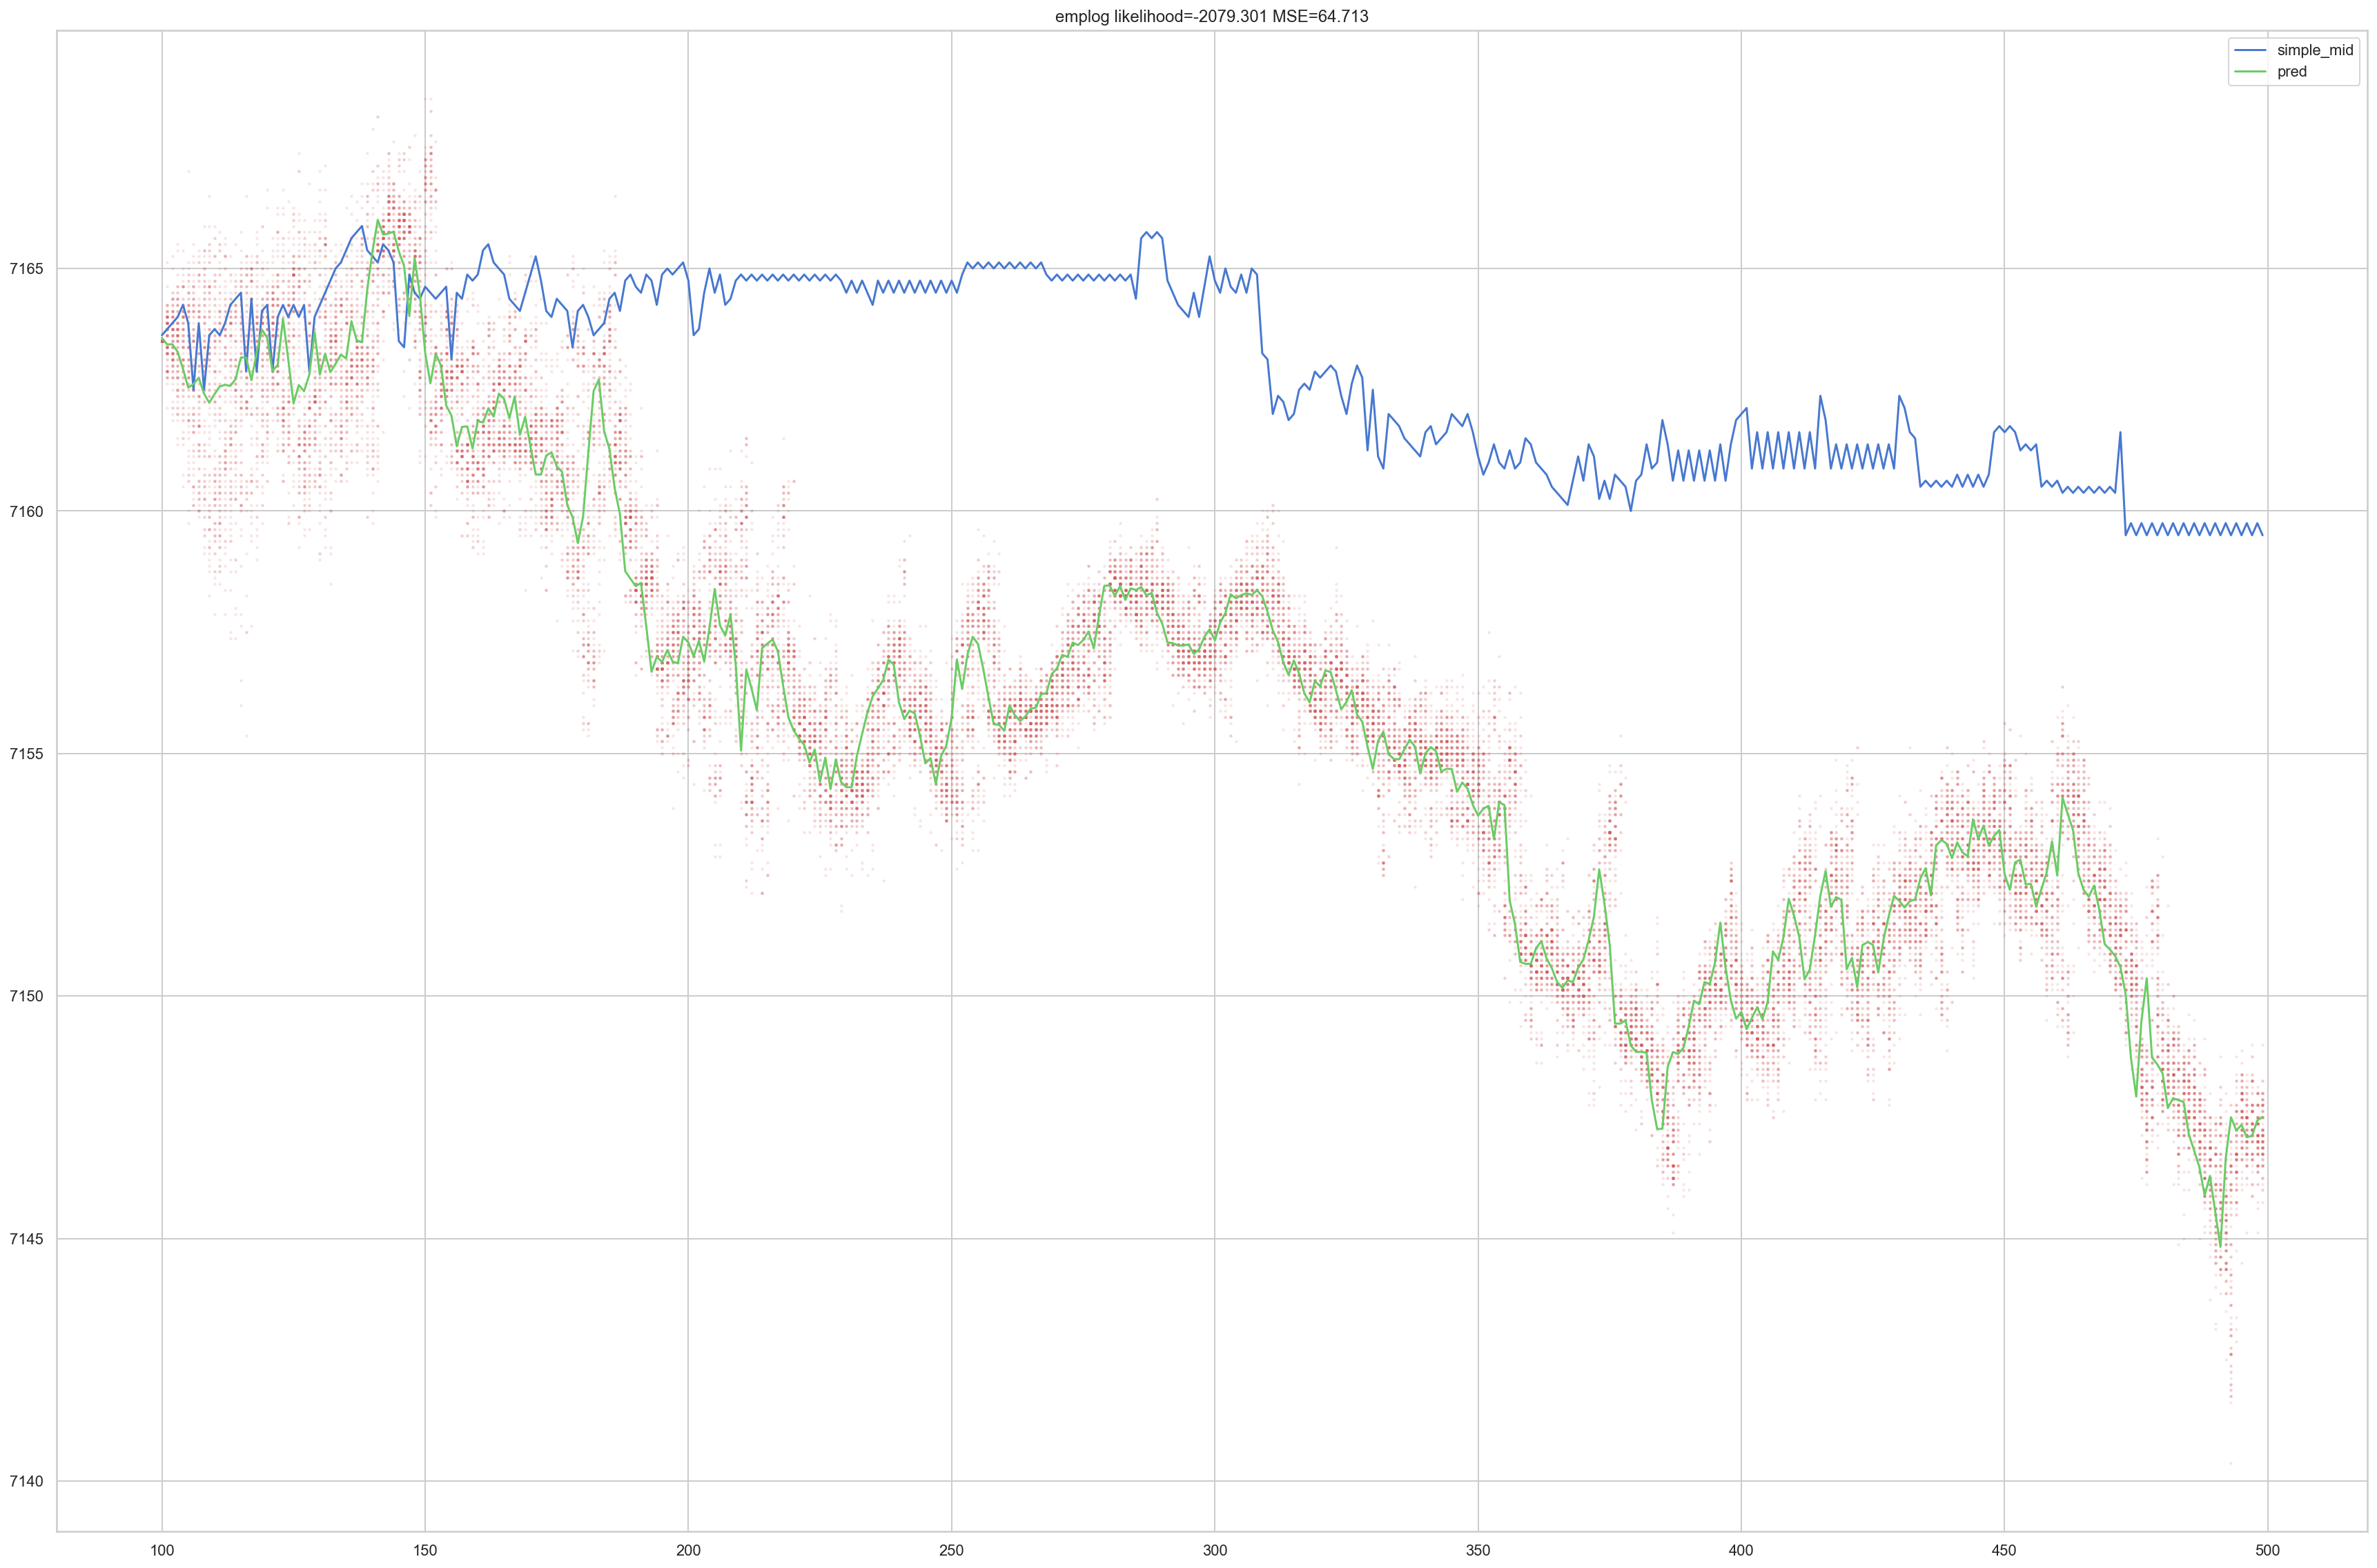

In [1012]:
## Backward Smoothed
pf.simulate(roll_window=100, method='emp', smoother='backward')
pf.draw_graph(lagged_weight=0)

 calculating... t=499

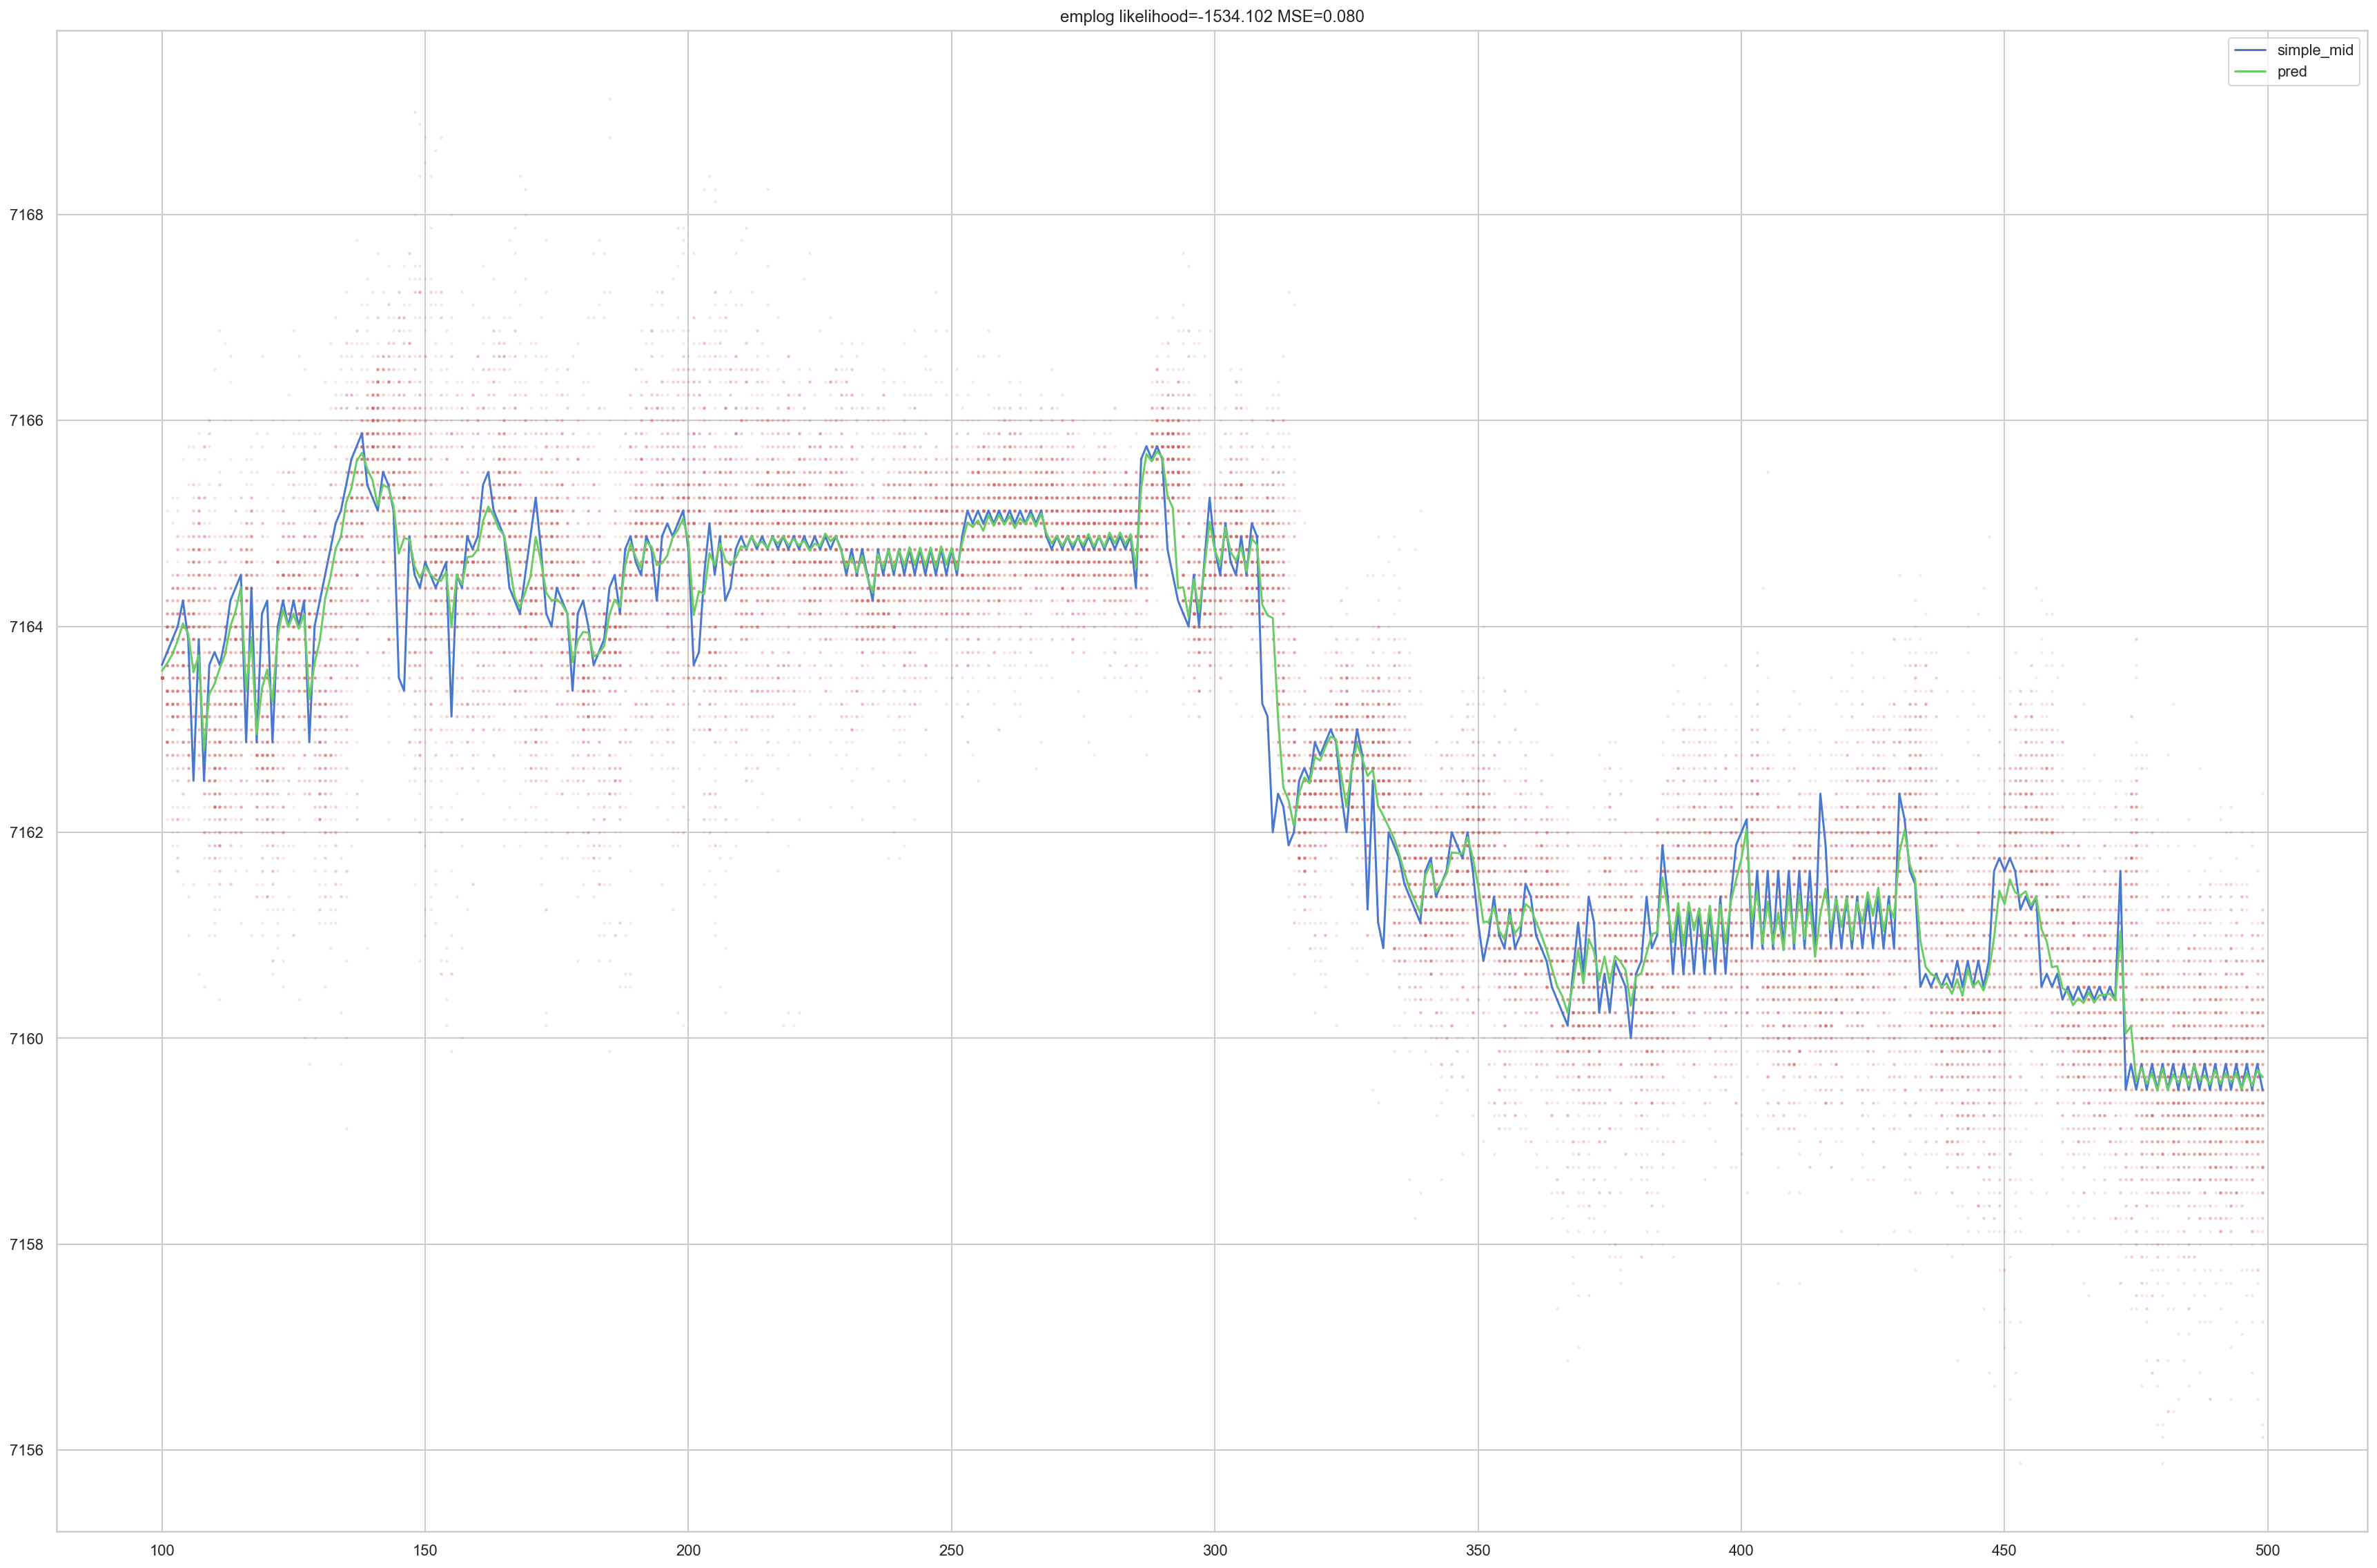

In [1013]:
## Fixed Lag Smoothed
pf.simulate(roll_window=100, method='emp', smoother='fixed_lag')
pf.draw_graph(lagged_weight=0)

 calculating... t=499

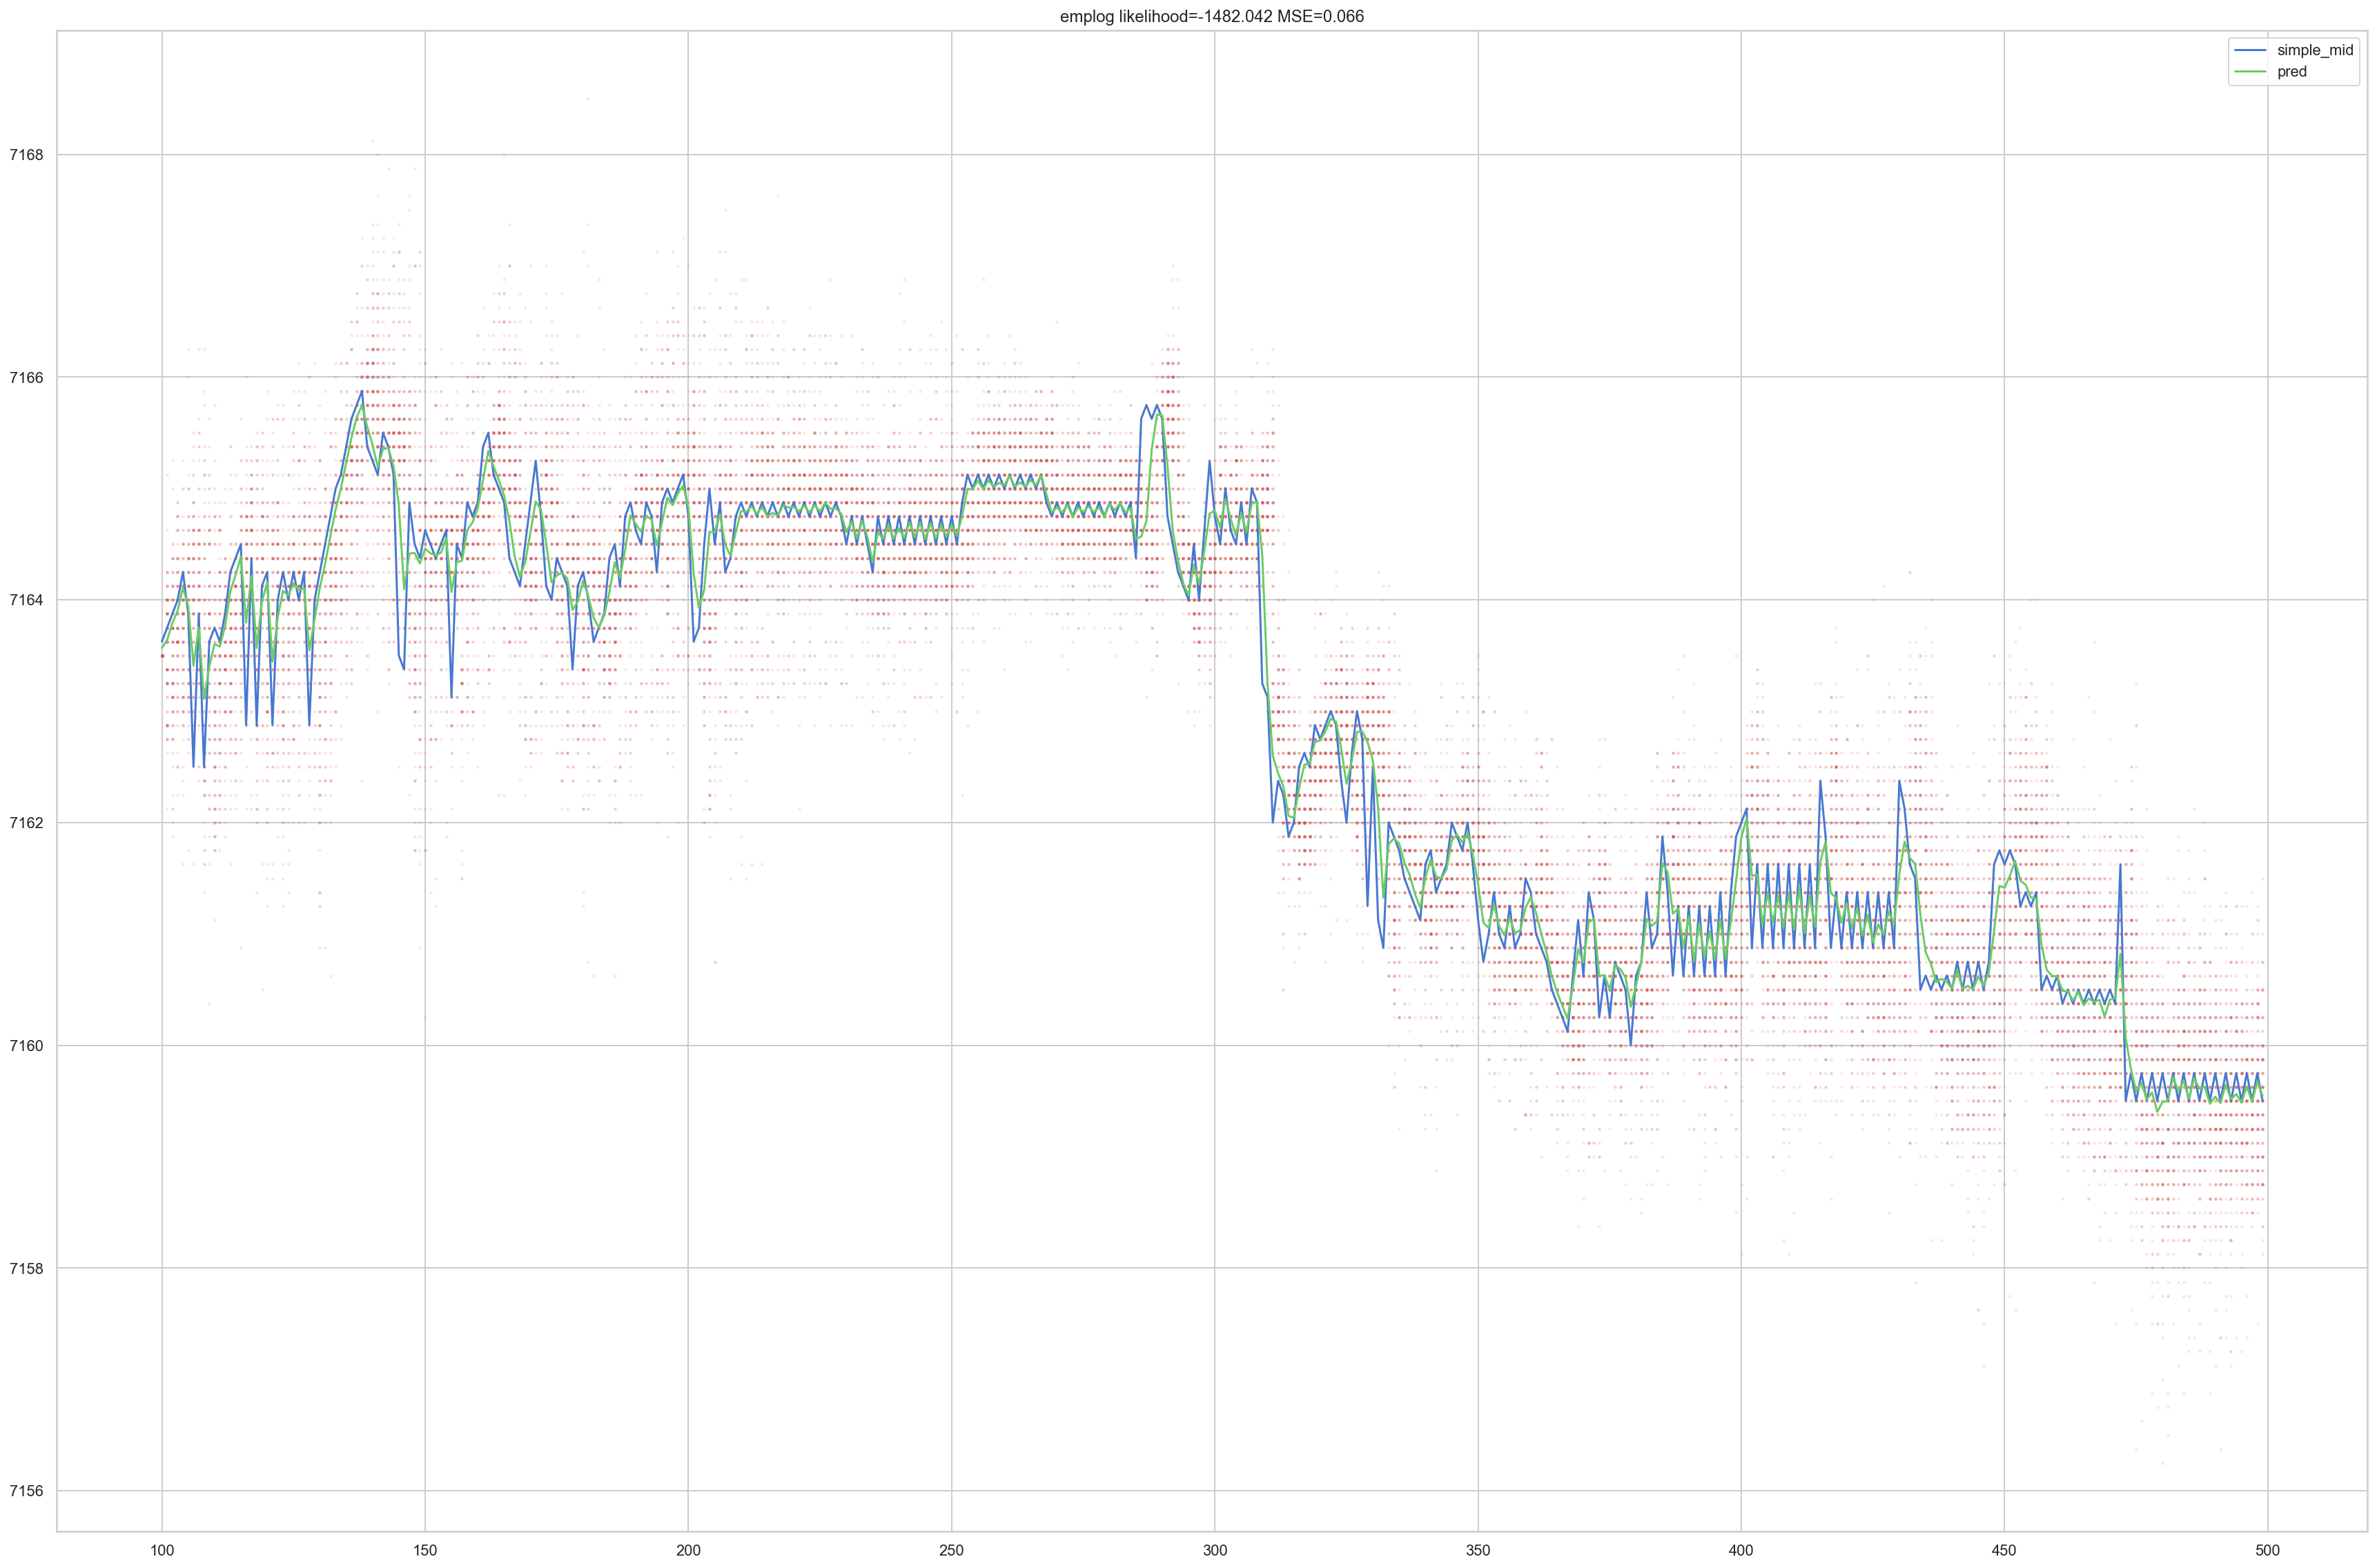

In [1014]:
## Unsmoothed
pf.simulate(roll_window=100, method='emp', smoother=None)
pf.draw_graph(lagged_weight=0)

 calculating... t=499

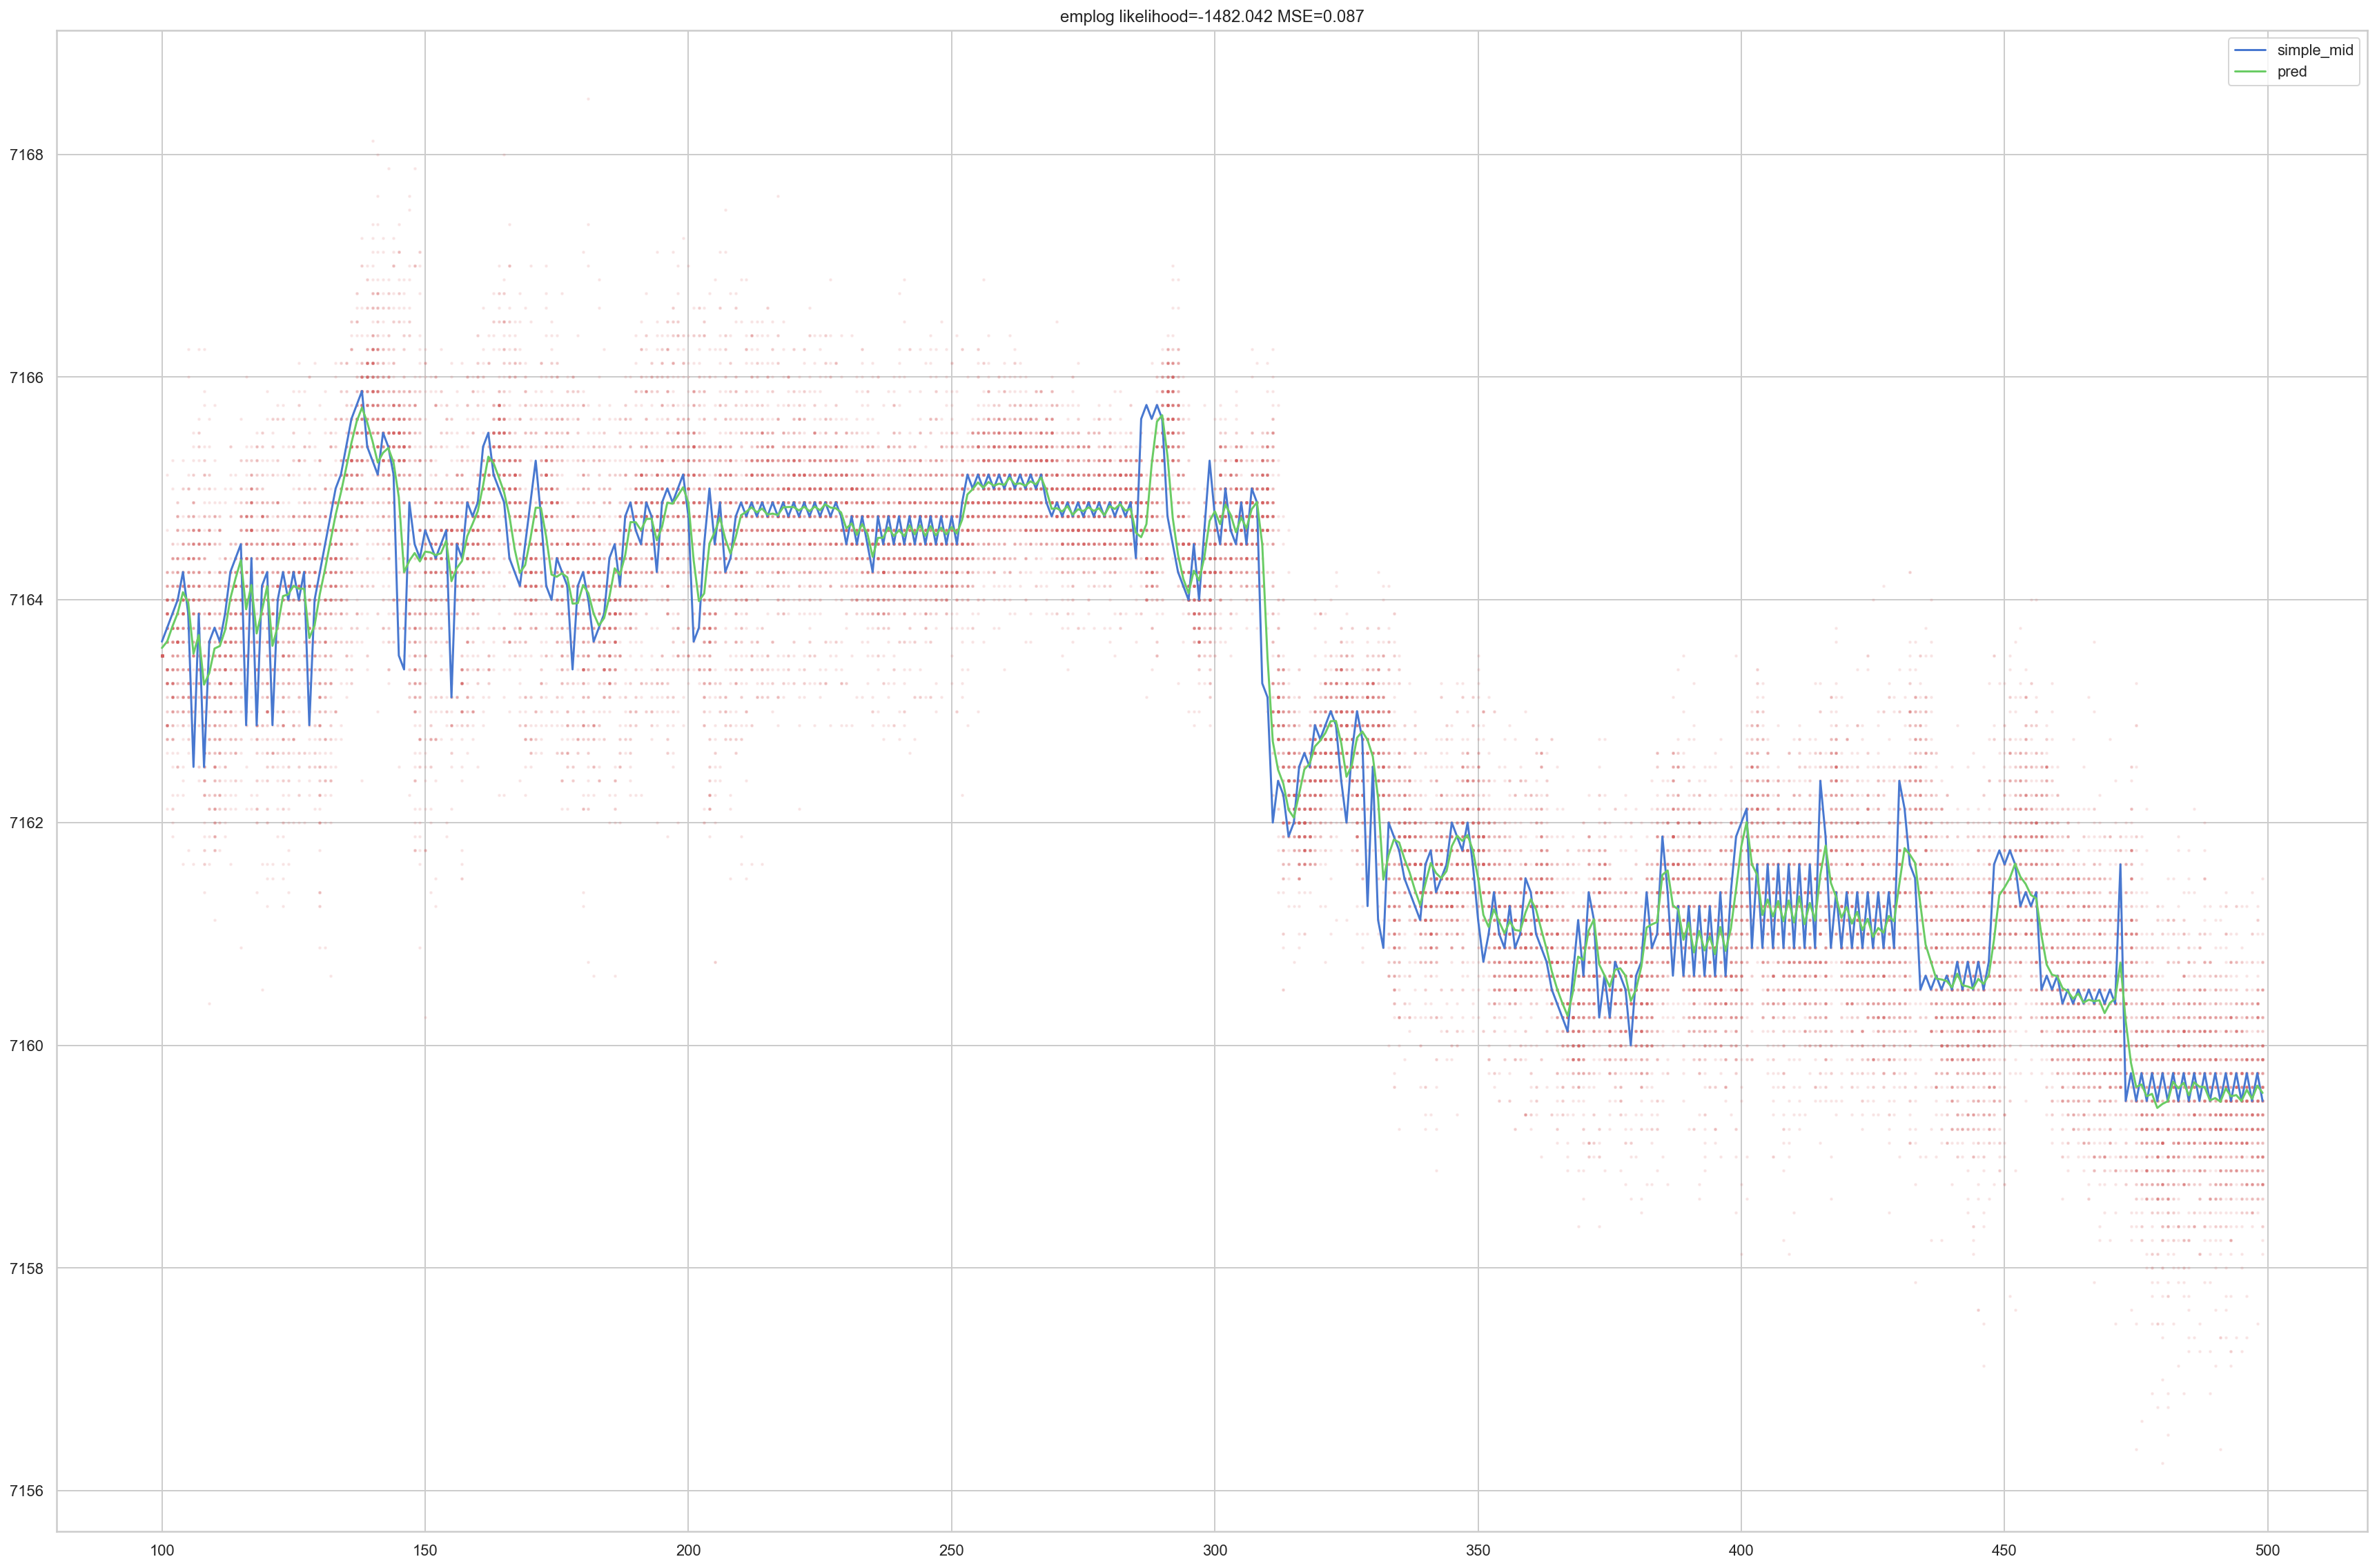

In [1015]:
## Smooth with 0.2 lagged x_mean
pf.simulate(roll_window=100, method='emp', smoother=None)
pf.draw_graph(lagged_weight=0.2)

 calculating... t=499

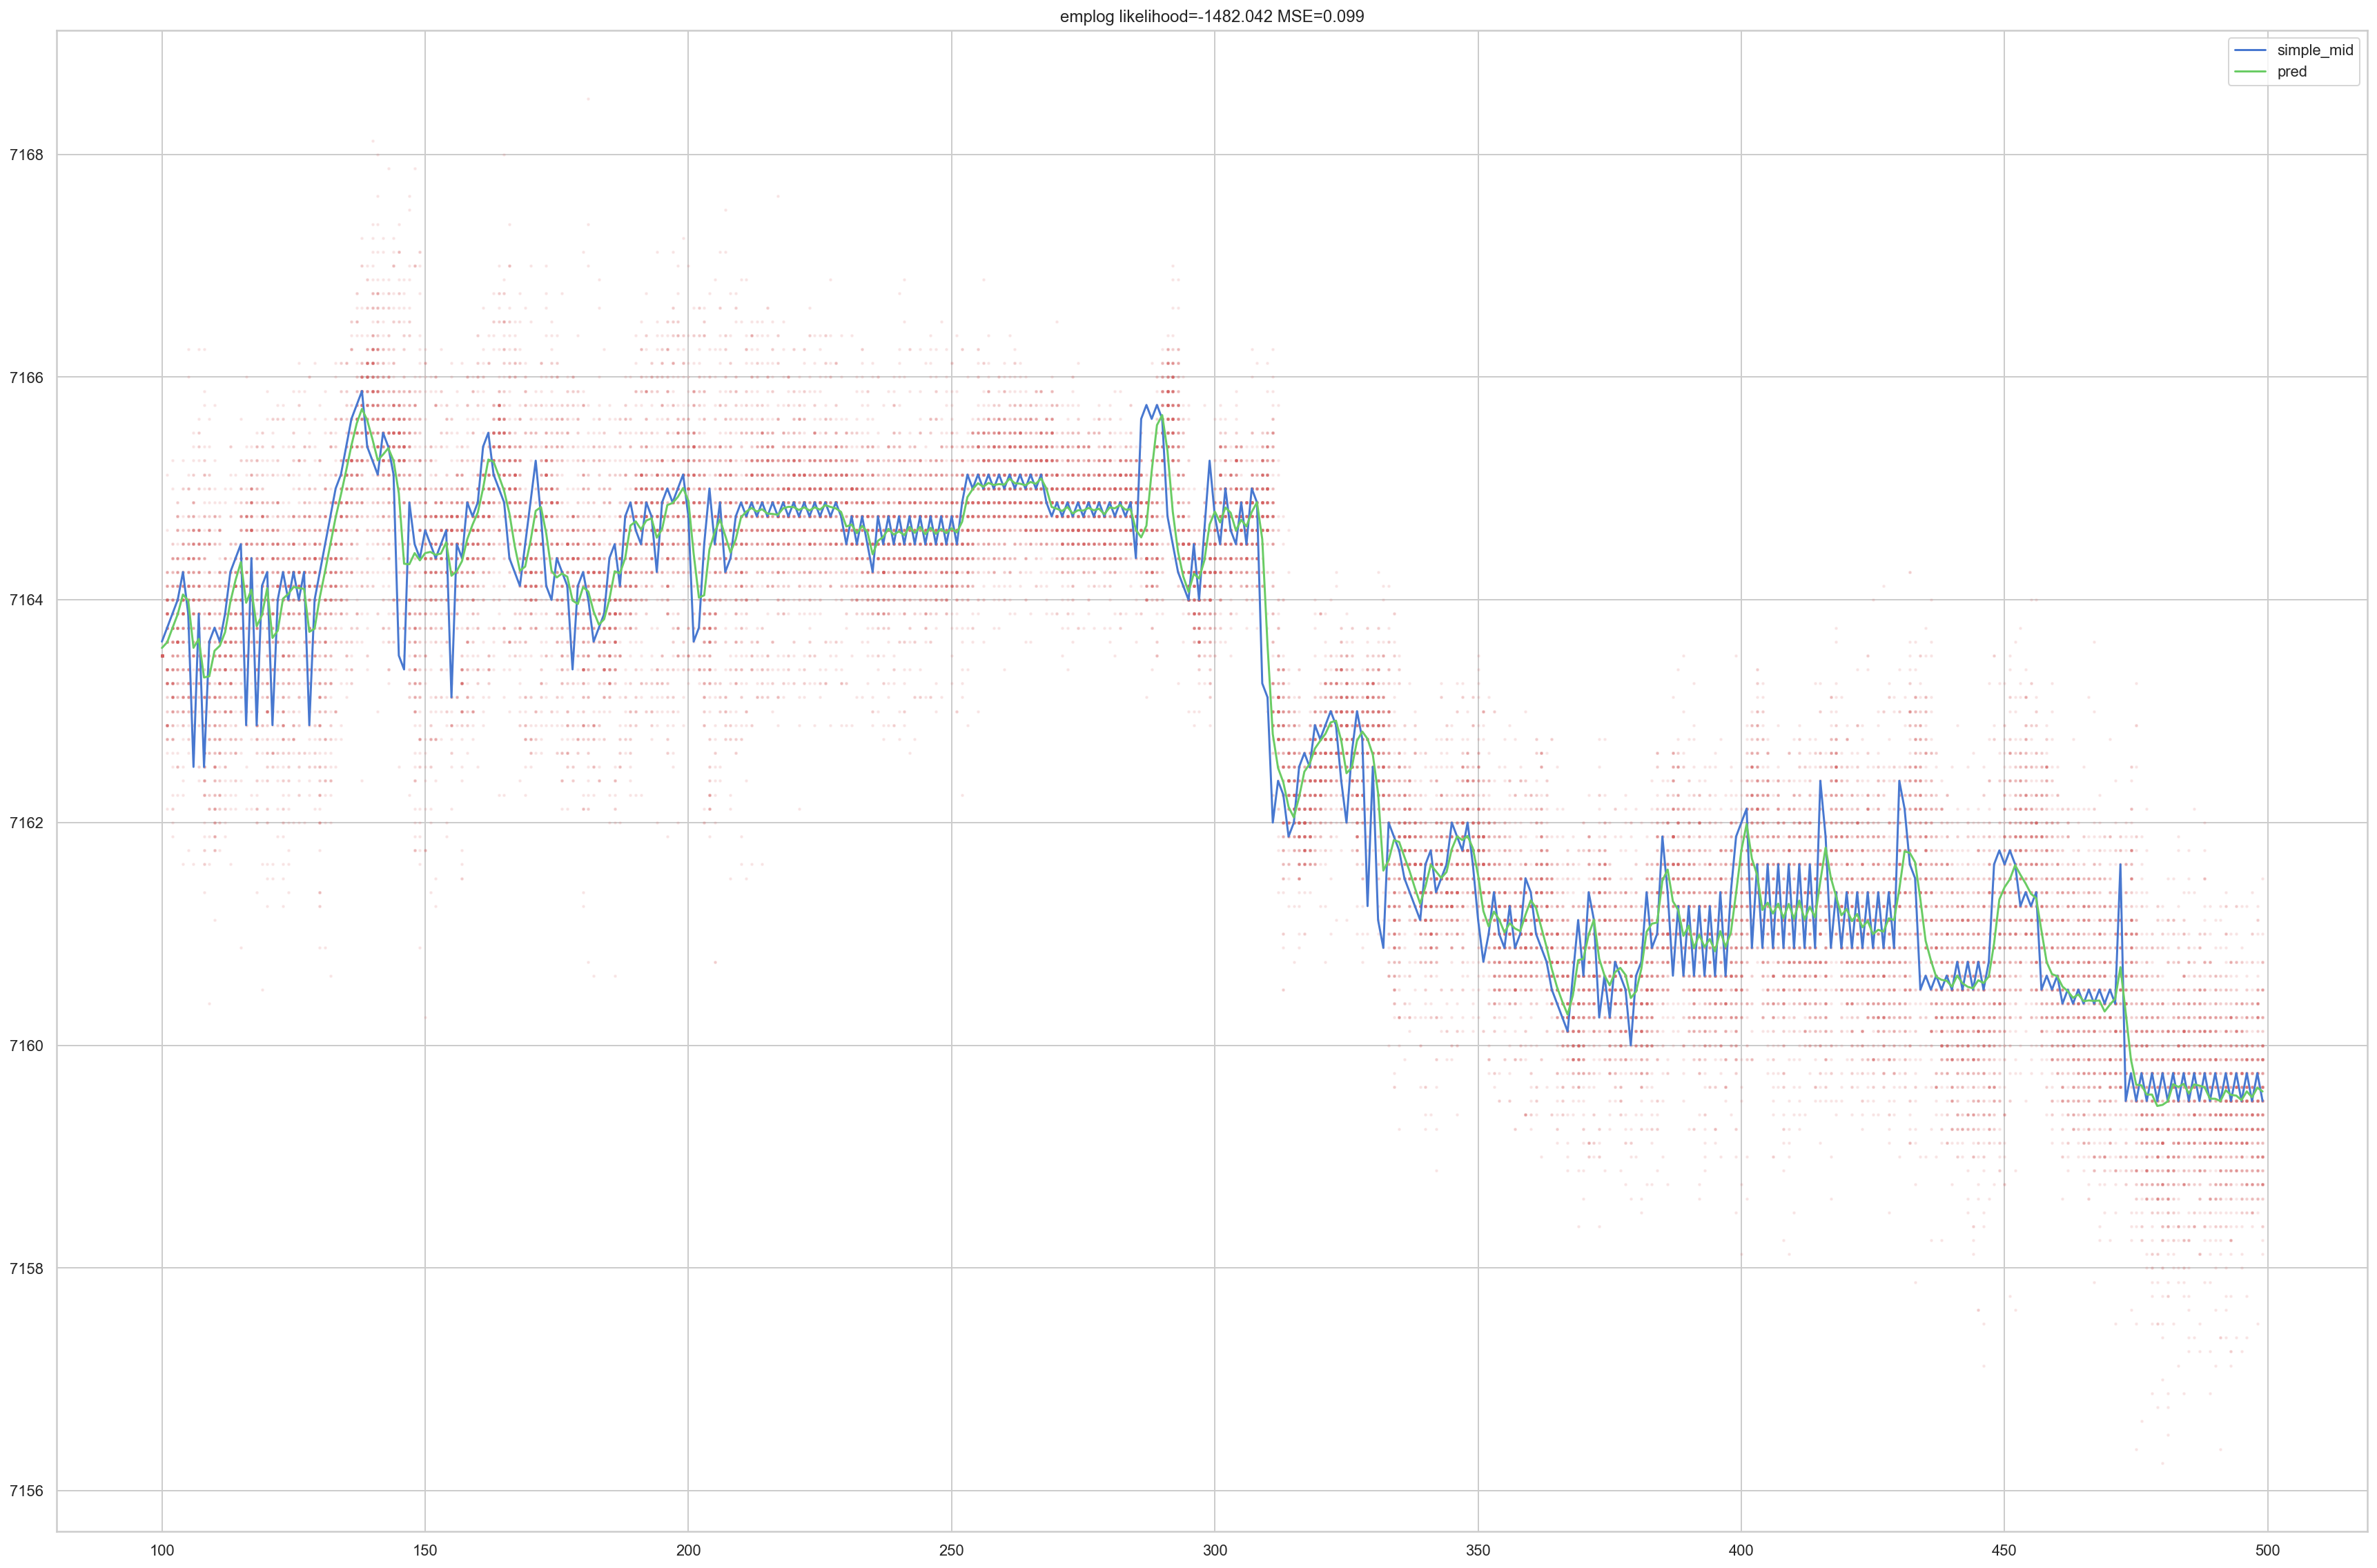

In [1016]:
## Smooth with 0.3 lagged x_mean
pf.simulate(roll_window=100, method='emp', smoother=None)
pf.draw_graph(lagged_weight=0.3)

 calculating... t=499

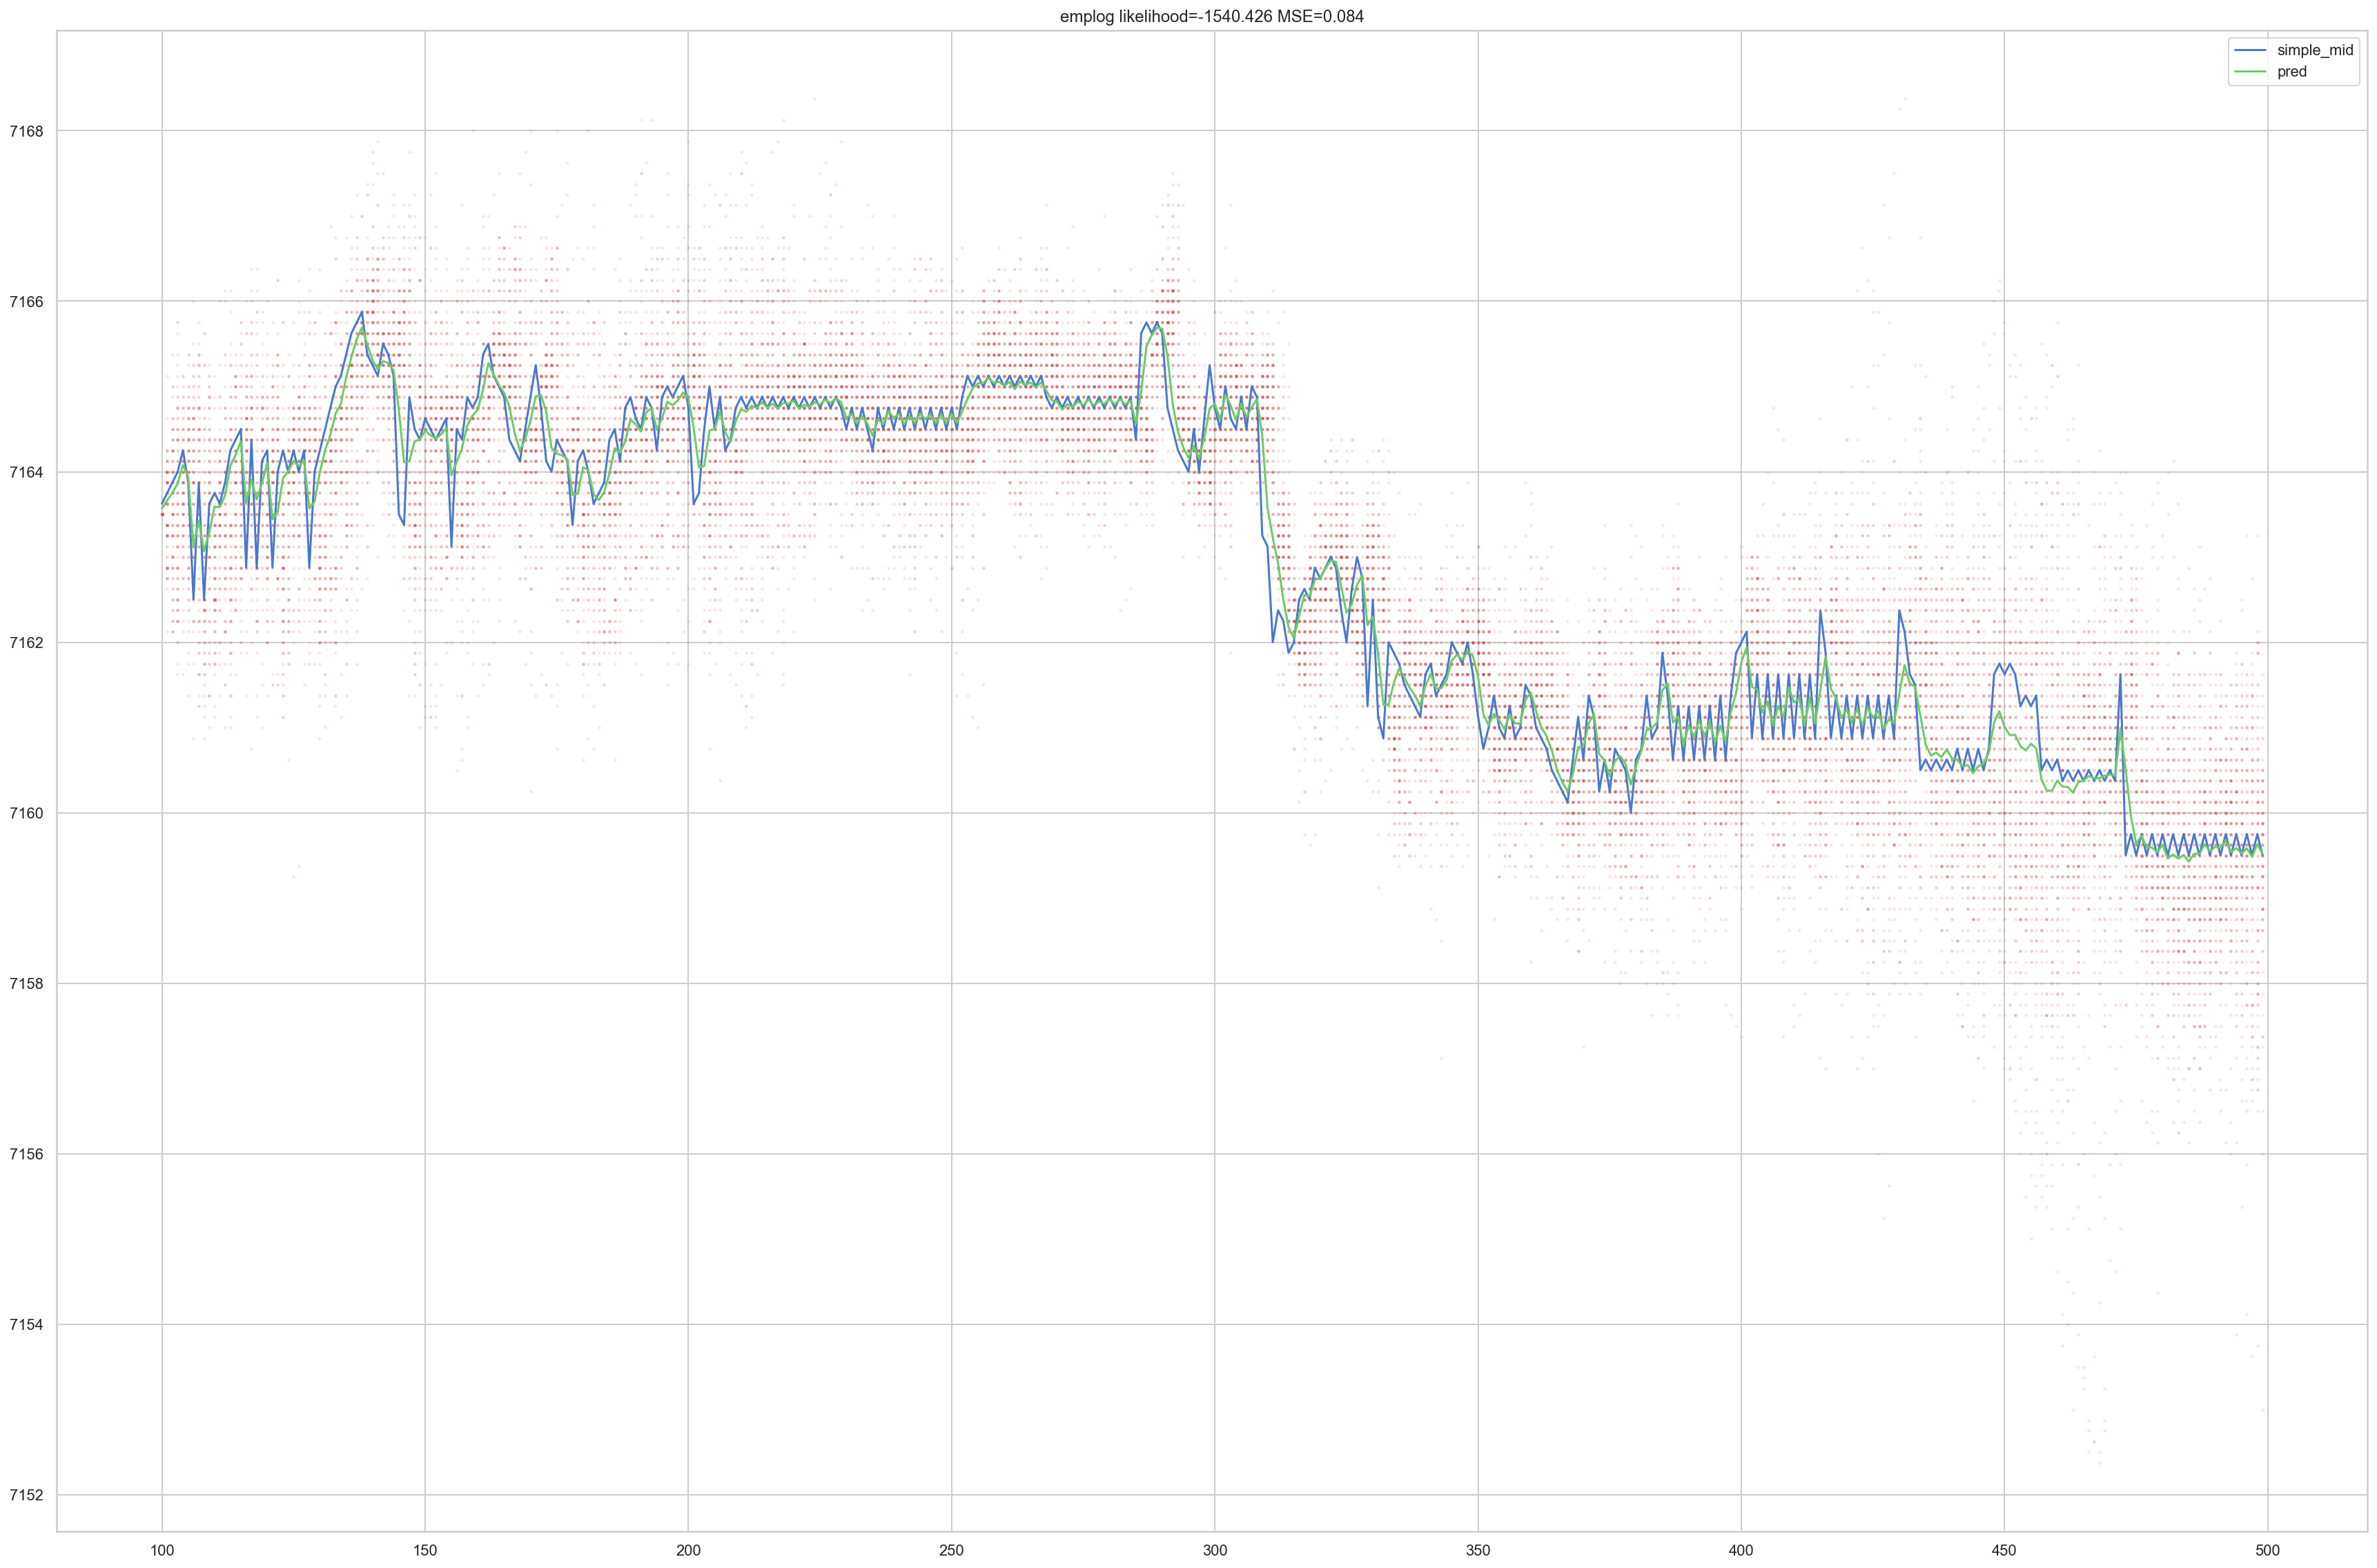

In [1021]:
## Smooth with Effective Sample Size
pf.simulate(roll_window=100, method='emp', smoother='ess')
pf.draw_graph(lagged_weight=0.2)

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  500
Model:                    local level   Log Likelihood                -330.353
Date:                Sun, 01 May 2022   AIC                            664.705
Time:                        22:09:43   BIC                            673.130
Sample:                             0   HQIC                           668.011
                                - 500                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0915      0.008     11.240      0.000       0.076       0.107
sigma2.level         0.0750      0.009      8.165      0.000       0.057       0.093
Ljung-Box (Q):              

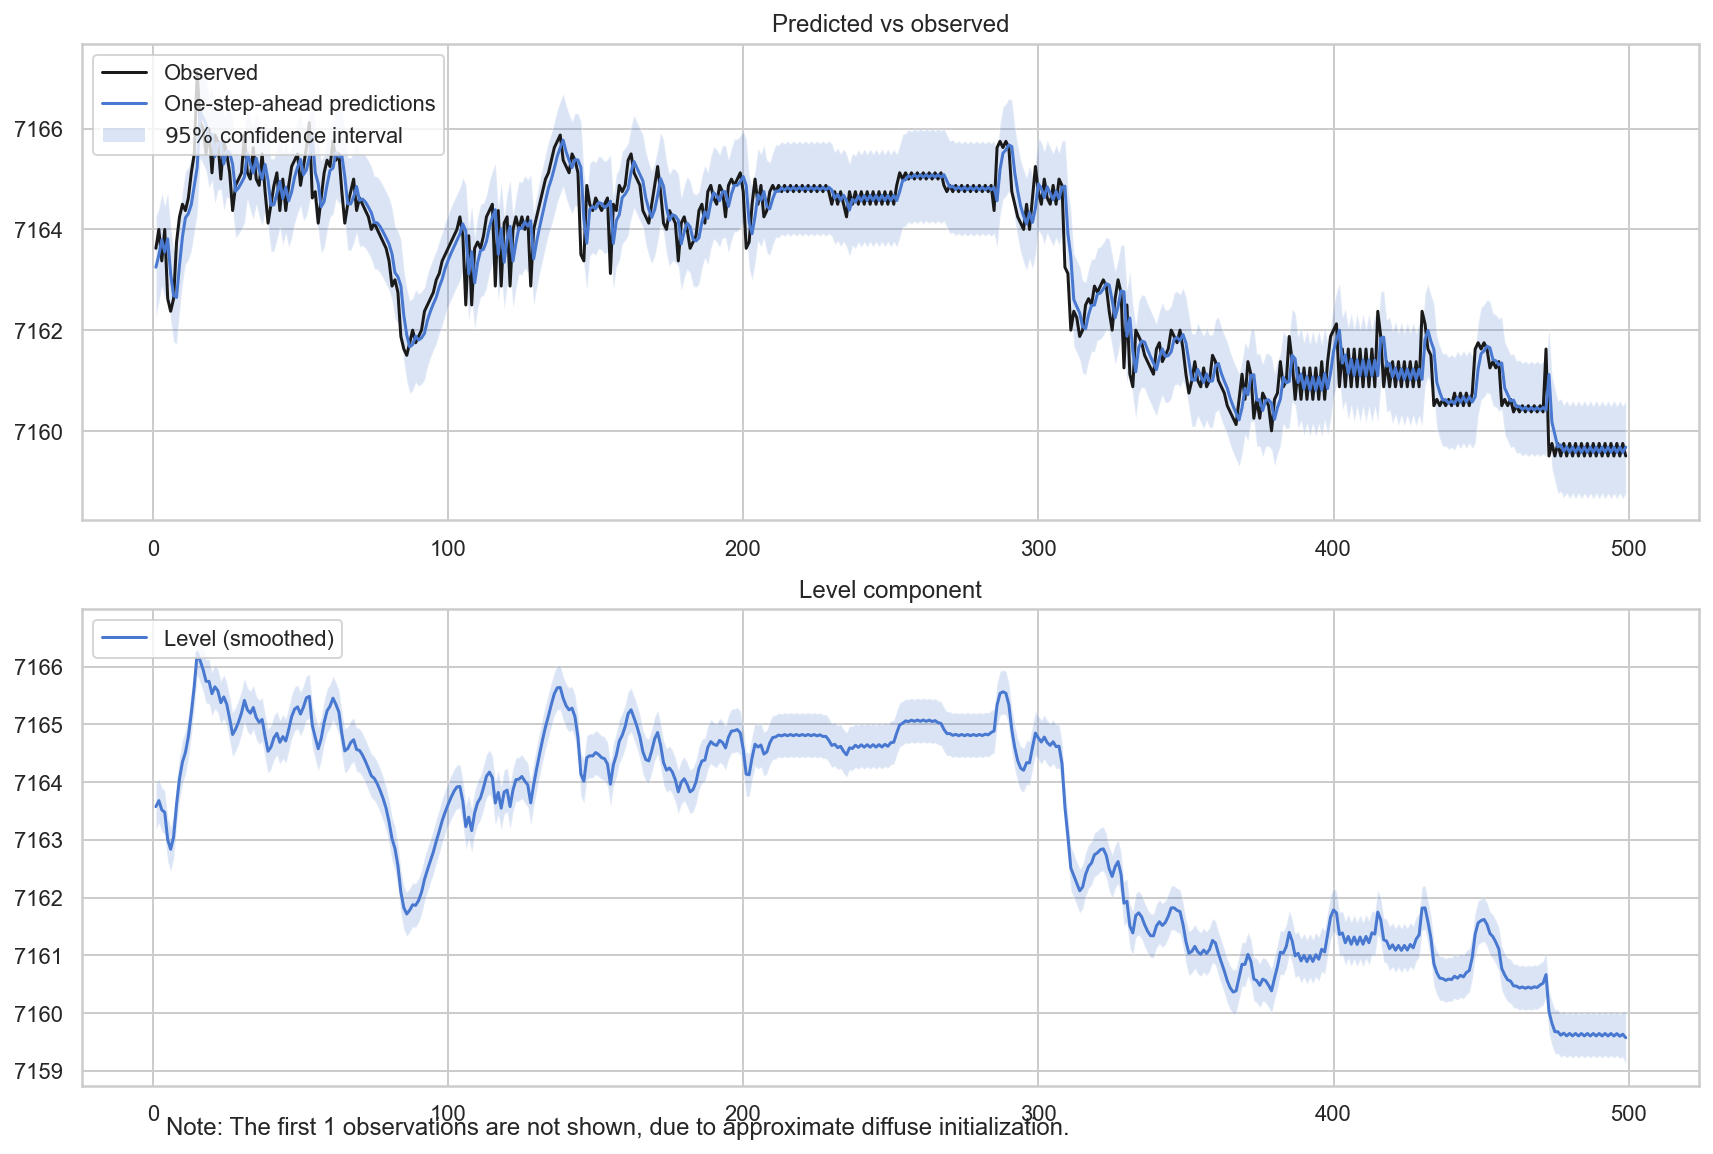

In [1023]:
# Unobserved Components Modeling (via Kalman Filter)の実行
import statsmodels.api as sm

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(cleaned_df.simple_mid.values[1000:1500], 'local level')
res_ll = mod_ll.fit()

print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components(legend_loc="upper left", figsize=(12,8))
plt.tight_layout()

In [1029]:
pf.y.shape

(500,)

 calculating... t=499

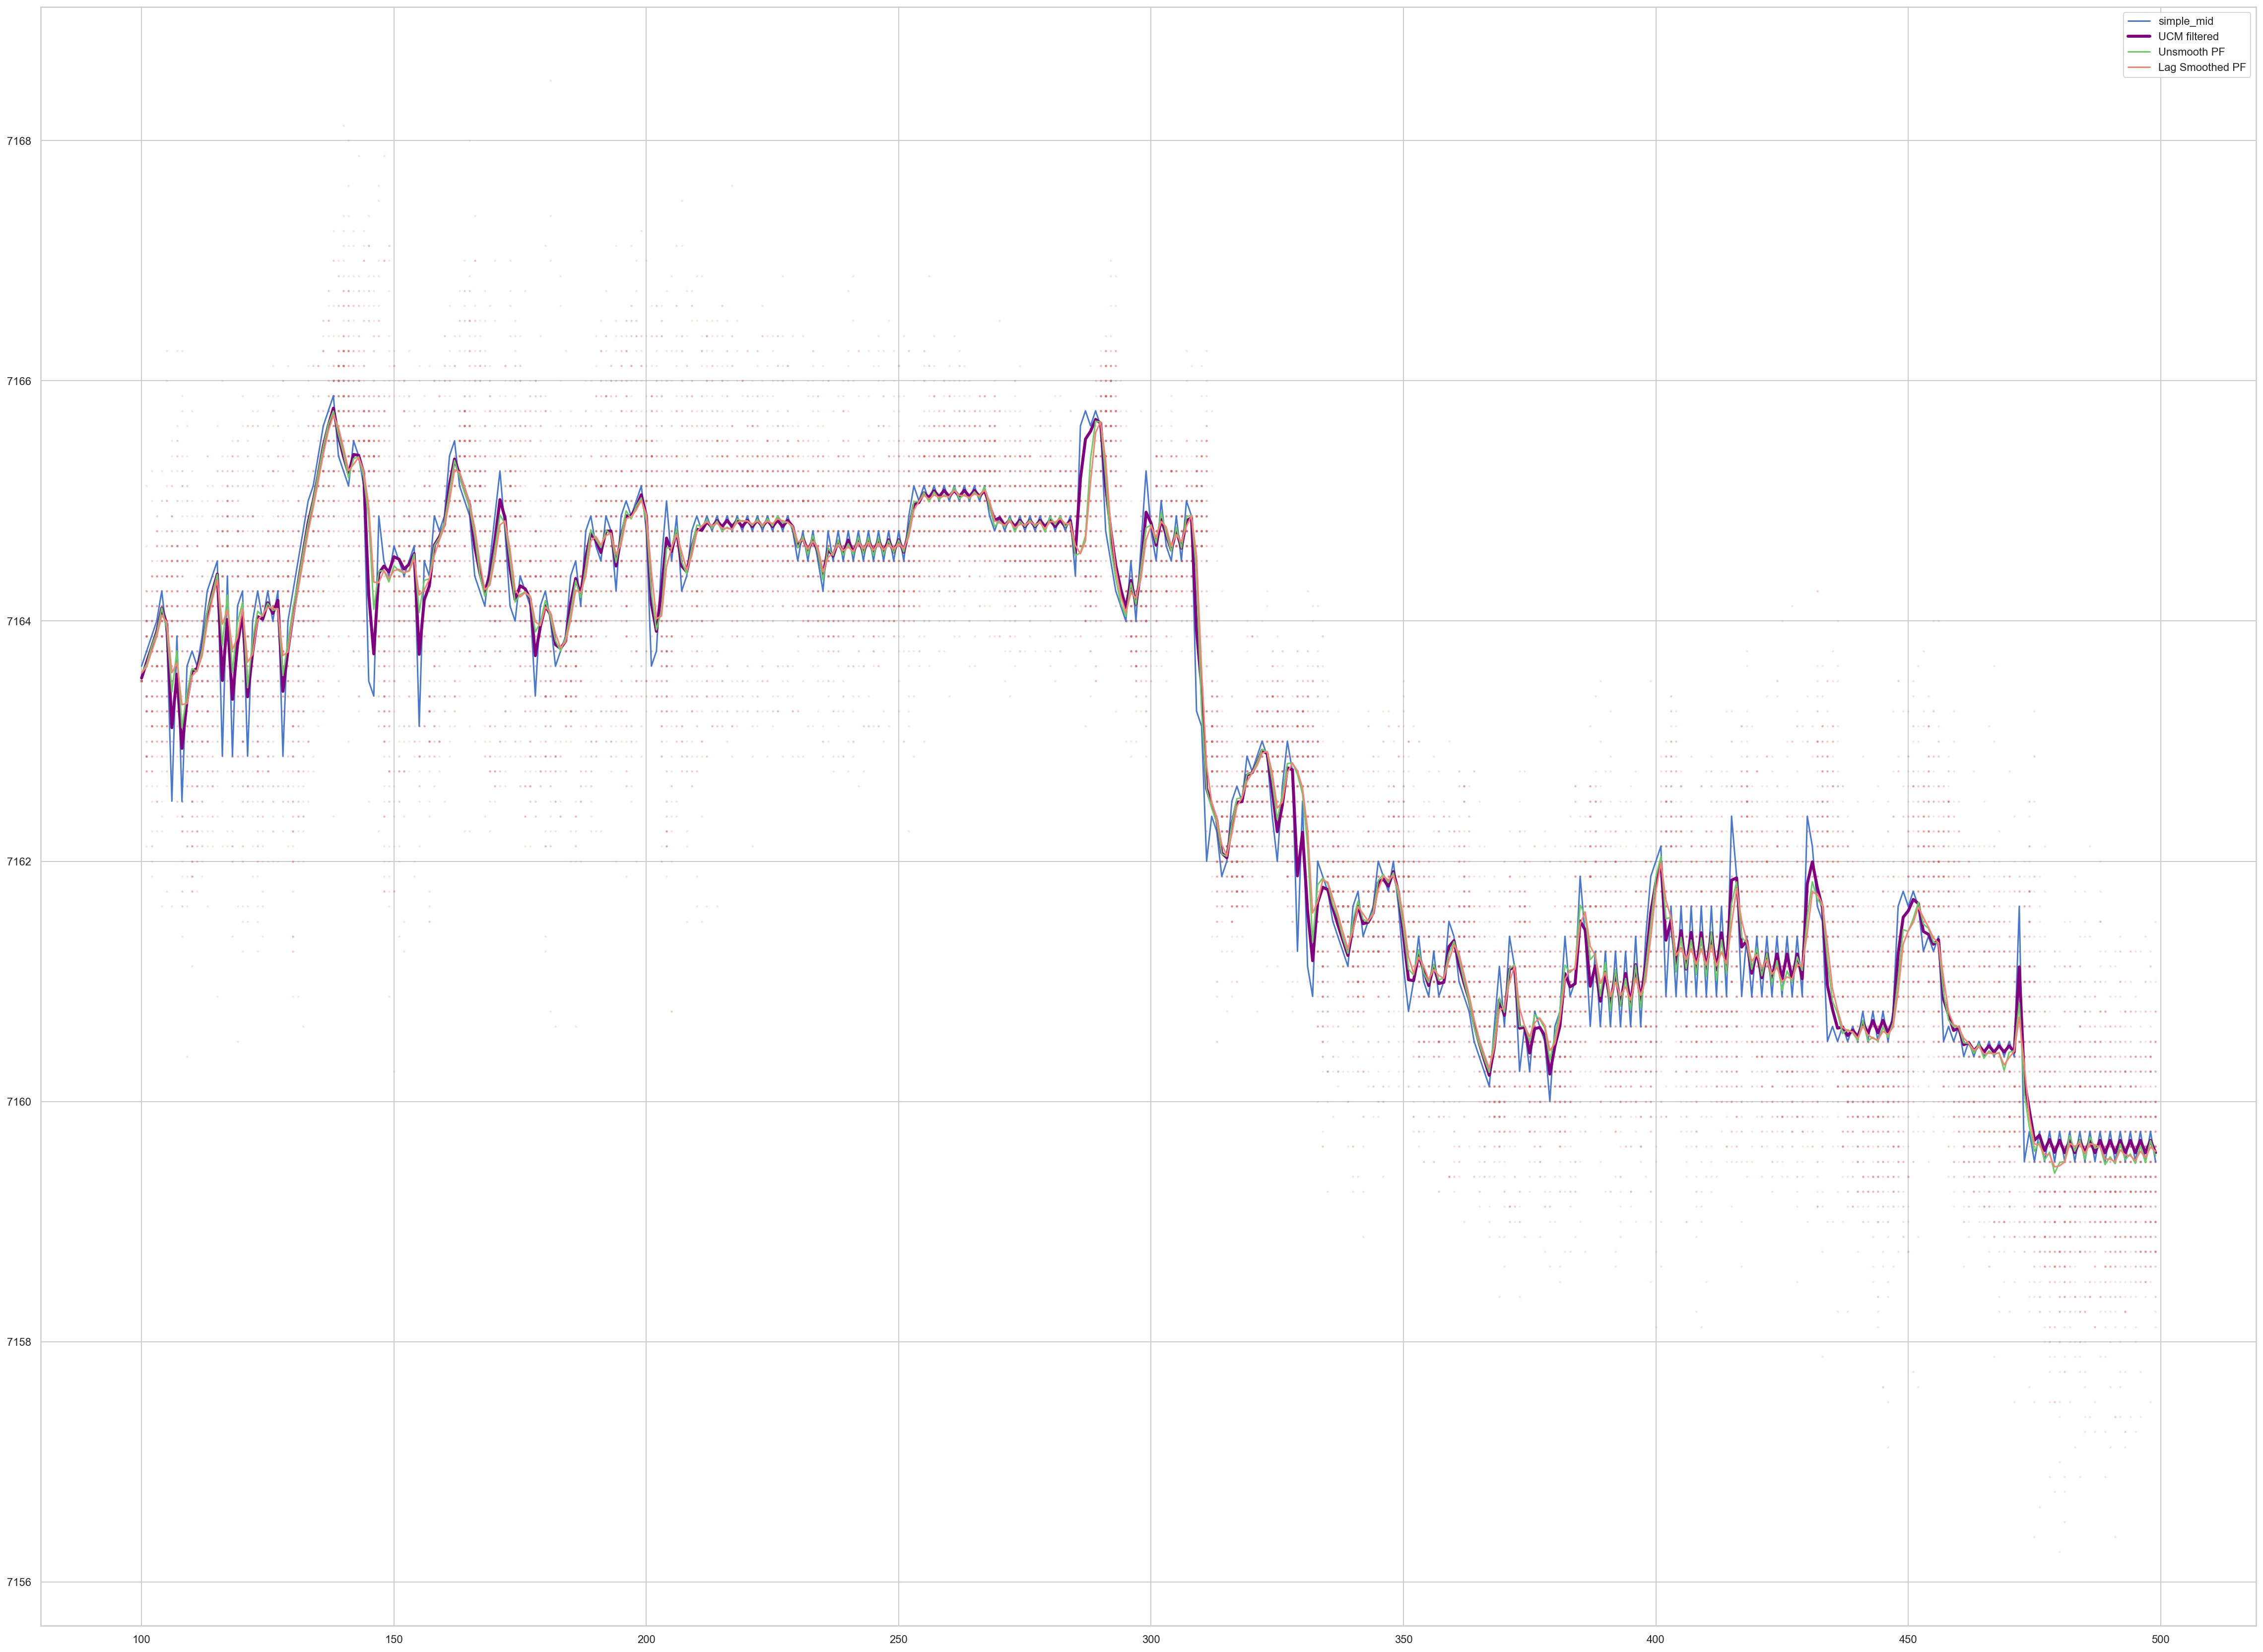

In [1047]:

pf.simulate(roll_window=100, method='emp', smoother=None)
# pf.draw_graph(lagged_weight=0)

t_x =  np.arange(pf.roll_window, T)
plt.figure(figsize=(40,30))
plt.plot(t_x, pf.y[pf.roll_window:], c="b", label="simple_mid")

ucm_filtered = res_ll.filtered_state.reshape(res_ll.filtered_state.shape[1])[pf.roll_window:]
plt.plot(t_x,ucm_filtered , "purple", lw=3, label="UCM filtered")

x_mean = pf.get_filtered_value(lagged_weight=0)[pf.roll_window:]
plt.plot(t_x, x_mean, c="g", label="Unsmooth PF")

x_mean = pf.get_filtered_value(lagged_weight=0.3)[pf.roll_window:]
plt.plot(t_x, x_mean, c="salmon", label="Lag Smoothed PF")


for t in t_x:
    plt.scatter(np.ones(pf.n_particle)*t, pf.x[t], color="r", s=2, alpha=0.1)

plt.legend()

In [1046]:
np.mean((ucm_filtered - pf.y[pf.roll_window:])**2)

0.03601303344019848

### ハイパーパラメータGrid Search

In [ ]:
\

In [12]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)

 calculating... t=99
-8 -5 -7611.96044829
 calculating... t=99
-8 -4 -7416.53359591
 calculating... t=99
-8 -3 -6945.7114457
 calculating... t=99
-8 -2 -5492.1615875
 calculating... t=99
-8 -1 -3489.9900233
 calculating... t=99
-8 0 -2025.10821314
 calculating... t=99
-8 1 -650.05245491
 calculating... t=99
-8 2 -99.5367503165
 calculating... t=99
-8 3 -166.346823516
 calculating... t=99
-8 4 -283.622339388
 calculating... t=99
-8 5 -404.570092007
 calculating... t=99
-7 -5 -3448.12851164
 calculating... t=99
-7 -4 -3601.86134724
 calculating... t=99
-7 -3 -3122.54848171
 calculating... t=99
-7 -2 -2422.72110264
 calculating... t=99
-7 -1 -1550.19261254
 calculating... t=99
-7 0 -852.610950039
 calculating... t=99
-7 1 -235.441257896
 calculating... t=99
-7 2 -108.901770598
 calculating... t=99
-7 3 -198.282423033
 calculating... t=99
-7 4 -314.256264291
 calculating... t=99
-7 5 -433.501336021
 calculating... t=99
-6 -5 -1394.77623755
 calculating... t=99
-6 -4 -1489.70717387
 calcula

In [13]:
idx = np.argmax(likelihood_list)
print("argmax idx:", idx)

print("likelihood={}, a:{}, b={}".format(likelihood_list[idx], a_list[idx], b_list[idx]))

argmax idx: 70
likelihood=-80.18725241309176, a:-2, b=-1
